# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Imports

Import all relevant libraries and classes used throughout the project. Key components include:

- **Torch** – for tensor operations and neural network functionality  
- **Datasets** – for handling training and evaluation data  
- **PyTorch Models** – custom and pre-defined models for the DEA  
- **Graph Matching Attack (GMA)** – core logic for the initial re-identification phase


In [1]:
import os

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision

from utils import get_hashes, reconstruct_words, run_epoch, convert_to_two_gram_scores, filter_two_grams, calculate_performance_metrics, label_tensors_to_two_grams

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import numpy as np
import string
import sys
from tqdm.notebook import tqdm

import seaborn as sns

from graphMatching.gma import run_gma

from datasets.bloom_filter_dataset import BloomFilterDataset
from datasets.tab_min_hash_dataset import TabMinHashDataset
from datasets.two_step_hash_dataset import TwoStepHashDataset

from pytorch_models.bloom_filter_to_two_gram_classifier import BloomFilterToTwoGramClassifier
from pytorch_models.tab_min_hash_to_two_gram_classifier import TabMinHashToTwoGramClassifier
from pytorch_models.two_step_hash_to_two_gram_classifier import TwoStepHashToTwoGramClassifier
from pytorch_models.test_model import TestModel

from early_stopping.early_stopping import EarlyStopping

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

Using NumPy dot (Mac)
System Version: 3.10.9 (main, Nov 22 2023, 17:43:49) [Clang 15.0.0 (clang-1500.0.40.1)]
PyTorch version 2.2.0
Torchvision version 0.17.0
Numpy version 1.24.4
Pandas version 2.0.3


## Parameters

Configuration and parameters for the Graph Matching Attack (GMA) and Dataset Extension Attack (DEA). For details and possible values, refer to the documentation at ```./docs/parameters.md```.

In [14]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./data/datasets/fakename_1k.tsv",
    "Overlap": 0.8,
    "DropFrom": "Eve",
    "Verbose": True,  # Print Status Messages
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False,
    "DevMode": False,
}


DEA_CONFIG = {
    "DevMode": False,
    # BCEWithLogitsLoss / MultiLabelSoftMarginLoss
    "LossFunction:": "BCEWithLogitsLoss",
    # Adam / AdamW / SGD / RMSprop
    "Optimizer": "RMSprop",
    "LearningRate": 1.0328170911570209e-05,
    # SGD only
    "Momentum": 0.9,
    "BatchSize": 64,
    "Epochs": 20,
    # TestSize calculated accordingly
    "TrainSize": 0.8,
    "FilterThreshold": 0.36691214615177686,
    "EarlyStoppingPatience": 10,
    "MinDelta": 1e-4,
    "TestModel": True,
    # relu / leaky_relu / gelu
    "ActivationFunction": "relu",
    # LR Scheduler
    "LRScheduler": "ReduceLROnPlateau",  # StepLR / ExponentialLR / ReduceLROnPlateau / CosineAnnealingLR / CyclicLR / None
    # StepLR & ExponentialLR
    "StepSize": 10,         # Used for StepLR
    "Gamma": 0.5,           # Used for StepLR & ExponentialLR
    # ReduceLROnPlateau
    "Mode": "min",          # Can be "min" or "max"
    "Factor": 0.4087306533176449,          # Multiplicative factor of learning rate decay
    "Patience": 5,          # Epochs with no improvement before reducing
    # CosineAnnealingLR
    "T_max": 50,            # Maximum number of iterations
    # CyclicLR
    "BaseLR": 1e-5,         # Lower bound of learning rate
    "MaxLR": 1e-3,          # Upper bound of learning rate
    "StepSizeUp": 2000,     # Steps to increase LR
    "ModeCyclic": "triangular2",  # Can be "triangular", "triangular2", "exp_range"
}

ENC_CONFIG = {
    # TwoStepHash / TabMinHash / BloomFilter
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "None",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":1, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

## 🔍 Data Preparation: Load or Compute Graph Matching Attack (GMA) Results

This code snippet either loads previously computed Graph Matching Attack (GMA) results from disk or runs the attack if no saved data is found.

1. **Generate Configuration Hashes:**  
   The function `get_hashes` creates unique hash values based on the encoding and embedding configurations. These are used to create distinct filenames for the data.

2. **Create File Paths:**  
   Based on the configuration hashes, paths are generated for:
   - Reidentified individuals
   - Not reidentified individuals
   - All individuals in Alice’s dataset (with encoding)

3. **Load Results from Disk (if available):**  
   If the `.h5` files already exist, they are loaded using `hickle` and converted into `pandas.DataFrames`.  
   The data format assumes that the first row contains the column headers, and the rest is the data — hence the slicing `[1:]` and `columns=...`.

4. **Run GMA If Data Is Not Available:**  
   If the files are missing, the GMA is executed via `run_gma()`. The results are again converted to `DataFrames`.


In [15]:
# Get unique hash identifiers for the encoding and embedding configurations
eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash = get_hashes(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG)

# Define file paths based on the configuration hashes
path_reidentified = f"./data/available_to_eve/reidentified_individuals_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"
path_not_reidentified = f"./data/available_to_eve/not_reidentified_individuals_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"
path_all = f"./data/dev/alice_data_complete_with_encoding_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"

# Check if the output files already exist
if os.path.isfile(path_reidentified) and os.path.isfile(path_not_reidentified) and os.path.isfile(path_all):
    # Load previously saved attack results
    print("Loading previously saved attack results...")
    reidentified_data = hkl.load(path_reidentified)
    not_reidentified_data = hkl.load(path_not_reidentified)
    all_data = hkl.load(path_all)

else:
    # Run Graph Matching Attack if files are not found
    reidentified_data, not_reidentified_data, all_data = run_gma(
        GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG, DEA_CONFIG,
        eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash
    )

# Convert lists to DataFrames
df_reidentified = pd.DataFrame(reidentified_data[1:], columns=reidentified_data[0])
df_not_reidentified = pd.DataFrame(not_reidentified_data[1:], columns=not_reidentified_data[0])
df_all = pd.DataFrame(all_data[1:], columns=all_data[0])
df_not_reidentified_labeled = df_all[df_all["uid"].isin(df_not_reidentified["uid"])].reset_index(drop=True)

Loading previously saved attack results...


## 🔤 Create 2-Gram Dictionary (Letters & Digits)

This code creates a comprehensive dictionary of all possible **2-grams** (two-character combinations) that consist of lowercase letters and digits.

1. **Character Sets:**
   - `string.ascii_lowercase`: the lowercase English alphabet ('a' to 'z')
   - `string.digits`: the digits '0' to '9'

2. **2-Gram Types Generated:**
   - **Letter-Letter (LL):** All combinations like `'aa'`, `'ab'`, ..., `'zz'` (26×26 = 676)
   - **Digit-Digit (DD):** All combinations like `'00'`, `'01'`, ..., `'99'` (10×10 = 100)
   - **Letter-Digit (LD):** All combinations like `'a0'`, `'a1'`, ..., `'z9'` (26×10 = 260)

3. **Combining All 2-Grams:**
   - All three types are concatenated into a single list.

4. **Indexed Dictionary:**
   - The `enumerate()` function is used to assign each 2-gram a unique index in `two_gram_dict`.


In [16]:
# --- Generate a dictionary of all possible 2-grams from letters and digits ---

# Lowercase alphabet: 'a' to 'z'
alphabet = string.ascii_lowercase

# Digits: '0' to '9'
digits = string.digits

# Generate all letter-letter 2-grams (e.g., 'aa', 'ab', ..., 'zz')
letter_letter_grams = [a + b for a in alphabet for b in alphabet]

# Generate all digit-digit 2-grams (e.g., '00', '01', ..., '99')
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]

# Generate all letter-digit 2-grams (e.g., 'a0', 'a1', ..., 'z9')
letter_digit_grams = [l + d for l in alphabet for d in digits]

# Combine all generated 2-grams into one list
all_two_grams = letter_letter_grams + letter_digit_grams + digit_digit_grams

# Create a dictionary mapping index to each 2-gram
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}

## 🧩 Dataset Creation Based on Alice’s Encoding Scheme

This section initializes the dataset objects depending on which encoding method Alice used. Each encoding requires a different preprocessing strategy for compatibility with downstream neural models.

### 1. Bloom Filter (`"BloomFilter"`)
- Uses binary Bloom filters to represent identifiers.
- Loads `BloomFilterDataset` objects.
- Stores the bit-length of the bloom filter.

### 2. Tabulation MinHash (`"TabMinHash"`)
- Applies a MinHash-based encoding.
- Loads `TabMinHashDataset`.
- Captures the length of each encoded vector.

### 3. Two-Step Hash with One-Hot Encoding (`"TwoStepHash"`)
- Extracts all **unique hash values** to build a consistent one-hot vector space.
- Constructs datasets using `TwoStepHashDatasetOneHotEncoding`.

> ⚙️ All dataset constructors are passed:
> - Whether the data is labeled
> - The full 2-gram list (used as feature tokens)
> - Additional encoding-specific configurations
> - Dev mode toggle (for debugging or smaller runs)


In [17]:
# 1️ Bloom Filter Encoding
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    data_labeled = BloomFilterDataset(
        df_reidentified,
        is_labeled=True,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    data_test = BloomFilterDataset(
        df_not_reidentified_labeled,
        is_labeled=True,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    bloomfilter_length = len(df_reidentified["bloomfilter"][0])

# 2️ Tabulation MinHash Encoding
elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    data_labeled = TabMinHashDataset(
        df_reidentified,
        is_labeled=True,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    data_test = TabMinHashDataset(
        df_not_reidentified_labeled,
        is_labeled=True,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    tabminhash_length = len(df_reidentified["tabminhash"][0])

# 3 Two-Step Hash Encoding (One-Hot Encoding Mode)
elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
    # Collect all unique integers across both reidentified and non-reidentified data
    unique_ints_reid = set().union(*df_reidentified["twostephash"])
    unique_ints_not_reid = set().union(*df_not_reidentified_labeled["twostephash"])
    unique_ints_sorted = sorted(unique_ints_reid.union(unique_ints_not_reid))
    unique_integers_dict = {i: val for i, val in enumerate(unique_ints_sorted)}

    data_labeled = TwoStepHashDataset(
        df_reidentified,
        is_labeled=True,
        all_integers=unique_ints_sorted,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    data_test = TwoStepHashDataset(
        df_not_reidentified_labeled,
        is_labeled=True,
        all_integers=unique_ints_sorted,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )

## Data Splitting & Loader Setup

After preprocessing the encoded data, we divide it into training, validation, and test sets using PyTorch's `DataLoader` and `random_split`.

### Dataset Proportions
- The proportion for the training set is defined in `DEA_CONFIG["TrainSize"]`.
- The remainder is used for validation.

### Splitting
- `data_labeled` (the reidentified individuals) is split into:
  - `data_train` for training
  - `data_val` for validation
- `data_not_labeled` (unidentified individuals) is used exclusively for testing.

### Dataloader Configuration
- **Training Loader**: shuffled for learning generalization.
- **Validation Loader**: also shuffled to vary batches during evaluation.
- **Test Loader**: also shuffled.


In [18]:
# Define dataset split proportions
train_size = int(DEA_CONFIG["TrainSize"] * len(data_labeled))
val_size = len(data_labeled) - train_size

# Split the reidentified dataset into training and validation sets
data_train, data_val = random_split(data_labeled, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
dataloader_train = DataLoader(
    data_train,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=True  # Important for training
)

dataloader_val = DataLoader(
    data_val,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=True  # Allows variation in validation batches
)

dataloader_test = DataLoader(
    data_test,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=True
)

## Model Instantiation Based on Encoding Scheme

The neural network model is selected dynamically based on the encoding technique used for Alice’s data.

### Supported Models:

- **BloomFilter** → `BloomFilterToTwoGramClassifier`  
  - Input: Binary vector (Bloom filter)  
  - Output: 2-gram prediction

- **TabMinHash** → `TabMinHashToTwoGramClassifier`  
  - Input: Tabulated MinHash signature  
  - Output: 2-gram prediction

- **TwoStepHash** → `TwoStepHashToTwoGramClassifier`  
  - Input: Length of the unique integers present
  - Output: 2-gram predicition
    
Each model outputs predictions over the set of all possible 2-grams (`all_two_grams`), and the input dimension is dynamically configured based on the dataset.


In [24]:
# Instantiate model based on selected encoding scheme

if DEA_CONFIG["TestModel"]:
    if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
        model = TestModel(
            input_dim=bloomfilter_length,
            output_dim=len(all_two_grams),
            hidden_layer=2048,
            num_layers=1,
            dropout_rate=0.20702933807967946,
            activation_fn="selu"
        )
#num_layers,hidden_layer_size,dropout_rate,activation_fn,optimizer,loss_fn,threshold,lr_scheduler,average_dice,average_precision,average_recall,average_f1,len_train,len_val,epochs
#1,2048,0.20702933807967946,selu,"{'name': 'RMSprop', 'lr': 1.0328170911570209e-05}",BCEWithLogitsLoss,0.36691214615177686,"{'name': 'ReduceLROnPlateau', 'mode': 'min', 'factor': 0.4087306533176449, 'patience': 5}",0.9727962500000001,0.9889048970234253,0.9586764533014707,0.9727967135613089,6400,1600,20

    elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
        model = TestModel(
            input_dim=bloomfilter_length,
            output_dim=len(all_two_grams),
            hidden_layer=2048,
            num_layers=1,
            dropout_rate=0.220451802221184,
            activation_fn="relu"
        )
    elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
        model = TestModel(
            input_dim=bloomfilter_length,
            output_dim=len(all_two_grams),
            hidden_layer=2048,
            num_layers=1,
            dropout_rate=0.220451802221184,
            activation_fn="relu"
        )

elif ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    model = BloomFilterToTwoGramClassifier(
        input_dim=bloomfilter_length,
        output_dim=len(all_two_grams)
    )

elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    model = TabMinHashToTwoGramClassifier(
        input_dim=tabminhash_length,
        output_dim=len(all_two_grams)
    )

elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
    model = TwoStepHashToTwoGramClassifier(
        input_dim=len(unique_ints_sorted),
        output_dim=len(all_two_grams)
    )

print(model)

TestModel(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SELU()
    (2): Dropout(p=0.20702933807967946, inplace=False)
    (3): Linear(in_features=2048, out_features=1036, bias=True)
  )
)


## Training Environment Setup
This code initializes the core components needed for training a neural network model.

1. TensorBoard Setup
    - Creates unique run name by combining:
    - Loss function type
    - Optimizer choice
    - Alice's algorithm
    - Initializes TensorBoard writer in runs directory
2. Device Configuration
    - Automatically selects GPU if available, falls back to CPU
    - Moves model to selected device
3. Loss Functions
    - `BCEWithLogitsLoss`: Binary Cross Entropy with Logits
    - `MultiLabelSoftMarginLoss`: Multi-Label Soft Margin Loss
4. Optimizers:
    - `Adam`: Adaptive Moment Estimation
    - `AdamW`: Adam with Weight Decay
    - `SGD`: Stochastic Gradient Descent (with momentum)
    - `RMSprop`: Root Mean Square Propagation

In [20]:
# Setup tensorboard logging
run_name = "".join([
    DEA_CONFIG["LossFunction:"],
    DEA_CONFIG["Optimizer"],
    ENC_CONFIG["AliceAlgo"],
    DEA_CONFIG["ActivationFunction"],
])
tb_writer = SummaryWriter(f"runs/{run_name}")

# Setup compute device (GPU/CPU)
compute_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(compute_device)

# Initialize loss function
match DEA_CONFIG["LossFunction:"]:
    case "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss(reduction='mean')
    case "MultiLabelSoftMarginLoss":
        criterion = nn.MultiLabelSoftMarginLoss(reduction='mean')
    case _:
        raise ValueError(f"Unsupported loss function: {DEA_CONFIG['LossFunction:']}")

# Initialize optimizer
match DEA_CONFIG["Optimizer"]:
    case "Adam":
        optimizer = optim.Adam(model.parameters(), lr=DEA_CONFIG["LearningRate"])
    case "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=DEA_CONFIG["LearningRate"])
    case "SGD":
        optimizer = optim.SGD(model.parameters(),
                            lr=DEA_CONFIG["LearningRate"],
                            momentum=DEA_CONFIG["Momentum"])
    case "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=DEA_CONFIG["LearningRate"])
    case _:
        raise ValueError(f"Unsupported optimizer: {DEA_CONFIG['Optimizer']}")

# Initialize learning rate scheduler
match DEA_CONFIG["LRScheduler"]:
    case "StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=DEA_CONFIG["StepSize"],
            gamma=DEA_CONFIG["Gamma"]
        )
    case "ExponentialLR":
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=DEA_CONFIG["Gamma"]
        )
    case "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=DEA_CONFIG["Mode"],
            factor=DEA_CONFIG["Factor"],
            patience=DEA_CONFIG["Patience"]
        )
    case "CosineAnnealingLR":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=DEA_CONFIG["T_max"]
        )
    case "CyclicLR":
        scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=DEA_CONFIG["BaseLR"],
            max_lr=DEA_CONFIG["MaxLR"],
            step_size_up=DEA_CONFIG["StepSizeUp"],
            mode=DEA_CONFIG["ModeCyclic"],
            cycle_momentum=False  # usually False for Adam/AdamW
        )
    case None | "None":
        scheduler = None
    case _:
        raise ValueError(f"Unsupported LR scheduler: {DEA_CONFIG['LRScheduler']}")


## Model Training with Early Stopping

The function `train_model` orchestrates the training process for the neural network, including both training and validation phases for each epoch. It also utilizes **early stopping** to halt training when the validation loss fails to improve over multiple epochs, avoiding overfitting.

### Key Phases:
1. **Training Phase**: 
   - The model is trained on the `dataloader_train`, computing the training loss using the specified loss function (`criterion`) and optimizer. Gradients are calculated, and the model parameters are updated.
  
2. **Validation Phase**:
   - The model is evaluated on the `dataloader_val` without updating weights. The validation loss is computed to track model performance on unseen data.

3. **Logging**: 
   - Training and validation losses are logged to both the console and **TensorBoard** for tracking model performance during training.

4. **Early Stopping**: 
   - If the validation loss does not improve after a certain number of epochs (defined by `DEA_CONFIG["Patience"]`), the training process is halted to prevent overfitting.

### Helper Functions:
- `run_epoch`: Handles a single epoch, either for training or validation, depending on the flag `is_training`.
- `log_metrics`: Logs the training and validation losses to the console and TensorBoard for each epoch.


In [21]:
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    val_loss = train_loss = 0.0
    early_stopper = EarlyStopping(patience=DEA_CONFIG["EarlyStoppingPatience"], min_delta=DEA_CONFIG["MinDelta"], verbose=GLOBAL_CONFIG["Verbose"])

    for epoch in range(DEA_CONFIG["Epochs"]):
        # Training phase
        model.train()
        train_loss = run_epoch(
            model, dataloader_train, criterion, optimizer,
            device, is_training=True, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler
        )
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = run_epoch(
            model, dataloader_val, criterion, optimizer,
            device, is_training=False, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler
        )
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        val_losses.append(val_loss)

        # Logging
        log_metrics(train_loss, val_loss, epoch, DEA_CONFIG["Epochs"])

        # Early stopping check
        if early_stopper(val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    return train_losses, val_losses

def log_metrics(train_loss, val_loss, epoch, total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs} - "
          f"Train loss: {train_loss:.4f}, "
          f"Validation loss: {val_loss:.4f}")
    tb_writer.add_scalar("Loss/train", train_loss, epoch + 1)
    tb_writer.add_scalar("Loss/validation", val_loss, epoch + 1)

train_losses, val_losses = train_model(
    model, dataloader_train, dataloader_val,
    criterion, optimizer, compute_device
    )

Validation: 100%|██████████| 3/3 [00:00<00:00, 340.56it/s]


Epoch 1/20 - Train loss: 0.6299, Validation loss: 0.5622
best_loss updated from  inf  to  0.5621505618095398


Validation: 100%|██████████| 3/3 [00:00<00:00, 364.97it/s]


Epoch 2/20 - Train loss: 0.5140, Validation loss: 0.4586
best_loss updated from  0.5621505618095398  to  0.4586029052734375


Validation: 100%|██████████| 3/3 [00:00<00:00, 458.01it/s]


Epoch 3/20 - Train loss: 0.4186, Validation loss: 0.3743
best_loss updated from  0.4586029052734375  to  0.37427269816398623


Validation: 100%|██████████| 3/3 [00:00<00:00, 444.31it/s]


Epoch 4/20 - Train loss: 0.3427, Validation loss: 0.3085
best_loss updated from  0.37427269816398623  to  0.3084924817085266


Validation: 100%|██████████| 3/3 [00:00<00:00, 395.63it/s]


Epoch 5/20 - Train loss: 0.2839, Validation loss: 0.2581
best_loss updated from  0.3084924817085266  to  0.2581291675567627


Validation: 100%|██████████| 3/3 [00:00<00:00, 438.78it/s]


Epoch 6/20 - Train loss: 0.2393, Validation loss: 0.2197
best_loss updated from  0.2581291675567627  to  0.21969647109508514


Validation: 100%|██████████| 3/3 [00:00<00:00, 403.87it/s]


Epoch 7/20 - Train loss: 0.2050, Validation loss: 0.1903
best_loss updated from  0.21969647109508514  to  0.19026261568069458


Validation: 100%|██████████| 3/3 [00:00<00:00, 425.53it/s]


Epoch 8/20 - Train loss: 0.1791, Validation loss: 0.1675
best_loss updated from  0.19026261568069458  to  0.16749767065048218


Validation: 100%|██████████| 3/3 [00:00<00:00, 424.31it/s]


Epoch 9/20 - Train loss: 0.1586, Validation loss: 0.1497
best_loss updated from  0.16749767065048218  to  0.14972898066043855


Validation: 100%|██████████| 3/3 [00:00<00:00, 366.83it/s]


Epoch 10/20 - Train loss: 0.1427, Validation loss: 0.1357
best_loss updated from  0.14972898066043855  to  0.13570126593112947


Validation: 100%|██████████| 3/3 [00:00<00:00, 325.62it/s]


Epoch 11/20 - Train loss: 0.1301, Validation loss: 0.1245
best_loss updated from  0.13570126593112947  to  0.12448557615280151


Validation: 100%|██████████| 3/3 [00:00<00:00, 435.21it/s]


Epoch 12/20 - Train loss: 0.1198, Validation loss: 0.1155
best_loss updated from  0.12448557615280151  to  0.11546342819929123


Validation: 100%|██████████| 3/3 [00:00<00:00, 374.01it/s]


Epoch 13/20 - Train loss: 0.1116, Validation loss: 0.1081
best_loss updated from  0.11546342819929123  to  0.1080964297056198


Validation: 100%|██████████| 3/3 [00:00<00:00, 434.58it/s]


Epoch 14/20 - Train loss: 0.1049, Validation loss: 0.1020
best_loss updated from  0.1080964297056198  to  0.10203580260276794


Validation: 100%|██████████| 3/3 [00:00<00:00, 428.75it/s]


Epoch 15/20 - Train loss: 0.0993, Validation loss: 0.0970
best_loss updated from  0.10203580260276794  to  0.09701014757156372


Validation: 100%|██████████| 3/3 [00:00<00:00, 460.96it/s]


Epoch 16/20 - Train loss: 0.0947, Validation loss: 0.0928
best_loss updated from  0.09701014757156372  to  0.0927938163280487


Validation: 100%|██████████| 3/3 [00:00<00:00, 447.38it/s]


Epoch 17/20 - Train loss: 0.0908, Validation loss: 0.0892
best_loss updated from  0.0927938163280487  to  0.08924182951450348


Validation: 100%|██████████| 3/3 [00:00<00:00, 452.28it/s]


Epoch 18/20 - Train loss: 0.0875, Validation loss: 0.0862
best_loss updated from  0.08924182951450348  to  0.08623283505439758


Validation: 100%|██████████| 3/3 [00:00<00:00, 433.91it/s]


Epoch 19/20 - Train loss: 0.0847, Validation loss: 0.0837
best_loss updated from  0.08623283505439758  to  0.08366241008043289


Validation: 100%|██████████| 3/3 [00:00<00:00, 404.41it/s]

Epoch 20/20 - Train loss: 0.0822, Validation loss: 0.0815
best_loss updated from  0.08366241008043289  to  0.08145528137683869


## Loss Visualization over Epochs

This code snippet generates a plot to visualize the **training loss** and **validation loss** across epochs. It's useful for tracking model performance during training and evaluating if overfitting is occurring (i.e., when validation loss starts increasing while training loss continues to decrease).

### Key Elements:
1. **Plotting the Losses**: 
   - The `train_losses` and `val_losses` are plotted over the epochs. 
   - The **blue line** represents the training loss, and the **red line** represents the validation loss.

2. **Legend**: 
   - A legend is added to distinguish between training and validation losses.

3. **Title and Labels**: 
   - The plot is titled "Training and Validation Loss over Epochs" for context.
   - **X-axis** represents the epoch number, and **Y-axis** represents the loss value.


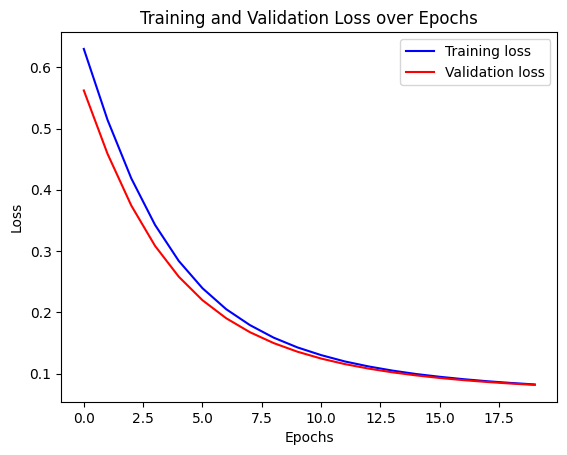

In [22]:
# Plot the training and validation losses over epochs
plt.plot(train_losses, label='Training loss', color='blue')
plt.plot(val_losses, label='Validation loss', color='red')

# Adding a legend to the plot
plt.legend()

# Setting the title and labels for clarity
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Show the plot
plt.show()

## Model Inference and 2-Gram Comparison

This code performs inference on the test data and compares the predicted 2-grams with the actual 2-grams, providing a performance evaluation based on the **Dice similarity coefficient**.

### Key Steps:

1. **Prepare for Evaluation**:
   - The model is switched to **evaluation mode** (`model.eval()`), ensuring no gradient computation.
   
2. **Thresholding**:
   - A threshold (`DEA_CONFIG["FilterThreshold"]`) is applied to filter out low-probability predictions, retaining only the most confident predictions.

3. **Inference and 2-Gram Scoring**:
   - The model is applied to the batch, and the **logits** are converted into probabilities using the **sigmoid function**.
   - The probabilities are then mapped to **2-gram scores**, and scores below the threshold are discarded.

4. **Reconstructing Words**:
   - For each sample in the batch, **2-grams** are reconstructed into words based on the filtered scores.

5. **Performance Metrics**:
   - The actual 2-grams (from the test dataset) are compared with the predicted 2-grams, and the **Dice similarity coefficient** is calculated for each sample.

### Result:
- The code generates a list `combined_results_performance`, which contains a detailed comparison for each UID, including:
  - **Actual 2-grams** (from the test data)
  - **Predicted 2-grams** (from the model)
  - **Dice similarity** score indicating how similar the actual and predicted 2-grams are.

In [23]:
# List to store decoded 2-gram scores for all test samples
decoded_test_results_words = []
result = []
total_precision = total_recall = total_f1 = total_dice = 0.0
n = len(dataloader_test.dataset)

# Switch to evaluation mode (no gradient computation during inference)
model.eval()

# Define Threshold for filtering predictions
threshold = DEA_CONFIG["FilterThreshold"]

# Loop through the test dataloader for inference
with torch.no_grad():  # No need to compute gradients during inference
    for data, labels, uid in tqdm(dataloader_test, desc="Test loop") if GLOBAL_CONFIG["Verbose"] else dataloader_test:

        actual_two_grams = label_tensors_to_two_grams(two_gram_dict, labels)

        # Move data to device and make predictions
        data = data.to(compute_device)
        logits = model(data)
        probabilities = torch.sigmoid(logits)

        # Convert probabilities into 2-gram scores
        batch_two_gram_scores = convert_to_two_gram_scores(two_gram_dict, probabilities)

        # Filter out low-scoring 2-grams
        batch_filtered_two_gram_scores = filter_two_grams(batch_two_gram_scores, threshold)

        # Calculate performance metrics for evaluation
        dice, precision, recall, f1 = calculate_performance_metrics(
            actual_two_grams, batch_filtered_two_gram_scores)
        total_dice += dice
        total_precision += precision
        total_recall += recall
        total_f1 += f1

        # Reconstruct words from the filtered 2-grams for each sample
        batch_reconstructed_words = [
            reconstruct_words(filtered_scores) for filtered_scores in batch_filtered_two_gram_scores
        ]

        for two_grams, two_grams_predicted, reconstructed_words, uid in zip(actual_two_grams, batch_filtered_two_gram_scores, batch_reconstructed_words, uid):
            # Create a dictionary to store the results for each test sample
            result_dict = {
                "uid": uid,
                "actual_two_grams": two_grams,
                "filtered_two_grams": two_grams_predicted,
                "reconstructed_words": reconstructed_words
            }
            # Append the result dictionary to the combined results list
            result.append(result_dict)

        average_precision = total_precision / n
        average_recall = total_recall / n
        average_f1 = total_f1 / n
        average_dice = total_dice / n


# Now `combined_results_performance` contains detailed comparison for all test samples
print(result)
print (f"Average Precision: {average_precision}")
print (f"Average Recall: {average_recall}")
print (f"Average F1 Score: {average_f1}")
print (f"Average Dice Similarity: {average_dice}")


Test loop:   0%|          | 0/4 [00:00<?, ?it/s]

[{'uid': '43574', 'actual_two_grams': ['ar', 'gi', 'il', 'ir', 'la', 'll', 'on', 'rg', 'rs', 'so', 'vi', 'n3', '13', '19', '31', '37', '93'], 'filtered_two_grams': ['19'], 'reconstructed_words': ['19']}, {'uid': '89172', 'actual_two_grams': ['ar', 'et', 'ga', 'hi', 'it', 'ma', 're', 'rg', 'te', 'tw', 'wh', 'e2', '19', '22', '27', '67', '71', '96'], 'filtered_two_grams': ['19'], 'reconstructed_words': ['19']}, {'uid': '44215', 'actual_two_grams': ['al', 'an', 'gh', 'ht', 'ig', 'la', 'nw', 'ri', 'wr', 't1', '01', '13', '19', '30', '88', '98'], 'filtered_two_grams': ['19'], 'reconstructed_words': ['19']}, {'uid': '44134', 'actual_two_grams': ['as', 'do', 'gl', 'in', 'ki', 'la', 'ng', 'ou', 'sk', 'ug', 'g1', '01', '10', '19', '39', '93'], 'filtered_two_grams': ['19'], 'reconstructed_words': ['19']}, {'uid': '6445', 'actual_two_grams': ['bs', 'co', 'di', 'hc', 'it', 'ju', 'mb', 'om', 'th', 'ud', 's7', '19', '24', '39', '41', '72', '93'], 'filtered_two_grams': ['19'], 'reconstructed_words': 

## Visualize Performance for Re-Identification

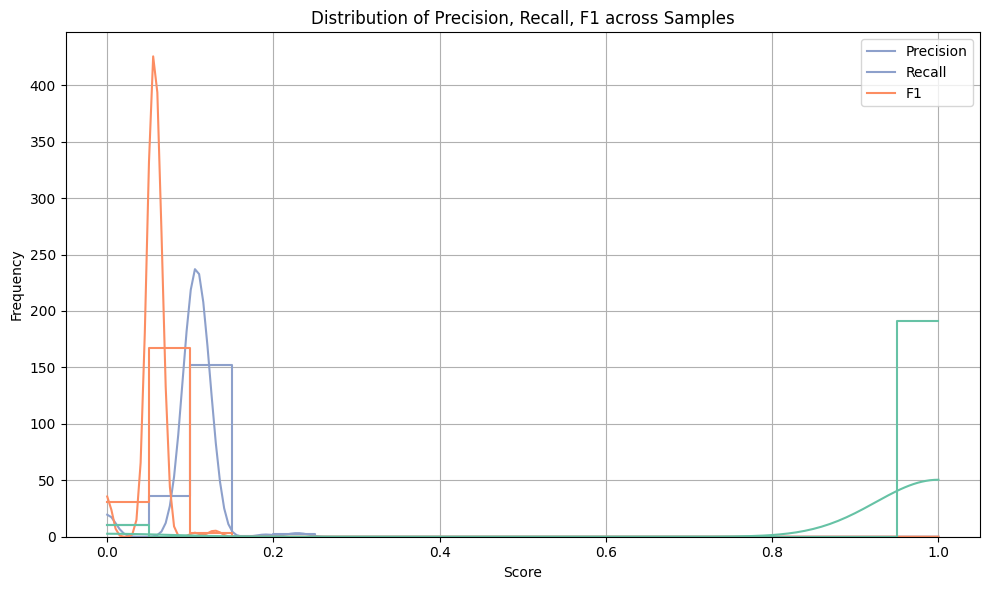


🔍 Sample Reconstructions (first 5):
UID: 32508
  Actual 2-grams:       ['ah', 'ea', 'ew', 'hl', 'is', 'le', 'wi', 's3', '11', '19', '21', '32', '66', '96']
  Predicted 2-grams:    ['19']
  Reconstructed Words:  ['19']
------------------------------------------------------------
UID: 42413
  Actual 2-grams:       ['di', 'ed', 'ep', 'hi', 'in', 'ix', 'jo', 'ne', 'on', 'os', 'ph', 'se', 'xo', 'n1', '11', '12', '19', '25', '51', '98', '99']
  Predicted 2-grams:    ['19']
  Reconstructed Words:  ['19']
------------------------------------------------------------
UID: 29927
  Actual 2-grams:       ['at', 'au', 'ch', 'ci', 'hu', 'ia', 'ic', 'pa', 'pc', 'rc', 'ri', 'tr', 'up', 'ur', 'h9', '19', '41', '45', '94']
  Predicted 2-grams:    ['19']
  Reconstructed Words:  ['19']
------------------------------------------------------------
UID: 10074
  Actual 2-grams:       ['au', 'do', 'en', 'lr', 'nd', 'on', 'pa', 're', 'ul', 'n1', '16', '19', '61', '72', '97']
  Predicted 2-grams:    ['19']
  Rec

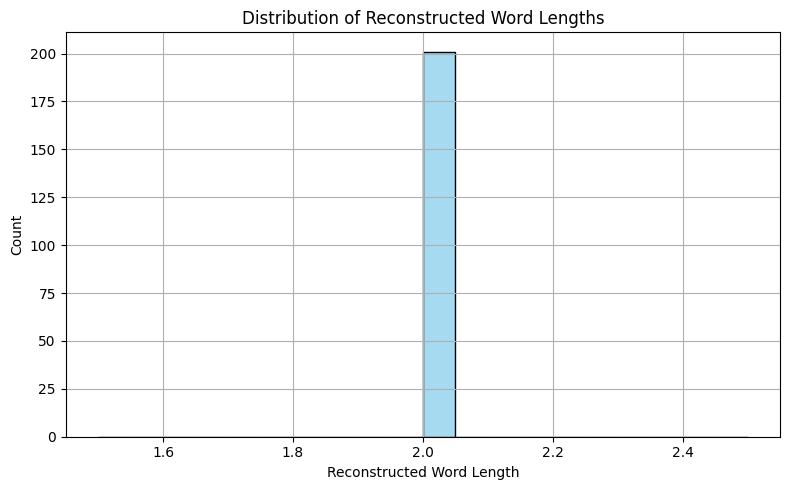

In [12]:
# Convert results to DataFrame
results_df = pd.DataFrame(result)

# Calculate per-sample 2-gram overlap metrics
def two_gram_overlap(row):
    actual = set(row['actual_two_grams'])
    predicted = set(row['filtered_two_grams'])
    intersection = actual & predicted
    return {
        "uid": row["uid"],
        "precision": len(intersection) / len(predicted) if predicted else 0,
        "recall": len(intersection) / len(actual) if actual else 0,
        "f1": 2 * len(intersection) / (len(actual) + len(predicted)) if actual and predicted else 0,
        "actual_len": len(actual),
        "predicted_len": len(predicted)
    }

overlap_df = pd.DataFrame([two_gram_overlap(row) for _, row in results_df.iterrows()])

# Plot 1: Distribution of precision, recall, F1
plt.figure(figsize=(10, 6))
sns.histplot(overlap_df[['precision', 'recall', 'f1']], bins=20, kde=True, palette='Set2', element="step", fill=False)
plt.title('Distribution of Precision, Recall, F1 across Samples')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(['Precision', 'Recall', 'F1'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Sample examples of reconstruction
print("\n🔍 Sample Reconstructions (first 5):")
for idx, row in results_df.head(5).iterrows():
    print(f"UID: {row['uid']}")
    print(f"  Actual 2-grams:       {row['actual_two_grams']}")
    print(f"  Predicted 2-grams:    {row['filtered_two_grams']}")
    print(f"  Reconstructed Words:  {row['reconstructed_words']}")
    print("-" * 60)

# Plot 3: Word length distribution
results_df["avg_predicted_piece_length"] = results_df["reconstructed_words"].apply(
    lambda x: np.mean([len(piece) for piece in x]) if x else 0
)
plt.figure(figsize=(8, 5))
sns.histplot(results_df["avg_predicted_piece_length"], bins=20, color="skyblue")
plt.title('Distribution of Reconstructed Word Lengths')
plt.xlabel('Reconstructed Word Length')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing Area

In [13]:
sys.exit("Stopping execution at this cell.")

SystemExit: Stopping execution at this cell.

/Users/I538952/Desktop/master/4-semester-thesis/dataset-extension-attack/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
